# PLAN2 : 학습 전 데이터 처리 

In [11]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import warnings
import time
import datetime

import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose,Reshape
from keras.layers import Activation, LeakyReLU, Dropout, BatchNormalization, MaxPooling2D
from keras.models import Model
from keras import backend as K 
from keras.optimizers import Adam

from sklearn.metrics import mean_squared_error as mse 

In [2]:
data = np.load('data/total_data.npy')

In [3]:
data.shape

(482, 448, 304, 5)

In [4]:
ice_con = data[...,0]
ice_con = ice_con.reshape(len(ice_con), 448, 304, 1)

In [5]:
ice_con.shape

(482, 448, 304, 1)

In [6]:
ice_con_250 = ice_con/250.
ice_con_250.dtype

dtype('float64')

In [61]:
train = ice_con_250[:-48]
test = ice_con_250[-48:]
print(train.shape, test.shape)

(434, 448, 304, 1) (48, 448, 304, 1)


In [62]:
split_len = int(len(train)*0.25 )

val = train[-split_len:]
train = train[:-split_len]

print(train.shape, val.shape)

(326, 448, 304, 1) (108, 448, 304, 1)


In [63]:
# 데이터셋 구성
# 2년(24개월 데이터) -> 향후 2년(24개월) 예측 

window_size = 24
target_days = 24

In [64]:
train_ds = tf.data.Dataset.from_tensor_slices(train
                                       ).window(window_size+target_days, shift = 1, drop_remainder = True
                                       ).flat_map(lambda w : w.batch(window_size + target_days)
                                       ).shuffle(1000
                                       ).map(lambda x : (x[:-target_days],x[-target_days:])
                                       ).batch(10)

In [65]:
for x, y in train_ds.take(1):
    print(x.shape)
    print(y.shape)

(10, 24, 448, 304, 1)
(10, 24, 448, 304, 1)


In [66]:
val_ds = tf.data.Dataset.from_tensor_slices(val
                                       ).window(window_size+target_days, shift = 1, drop_remainder = True
                                       ).flat_map(lambda w : w.batch(window_size + target_days)
                                       ).shuffle(1000
                                       ).map(lambda x : (x[:-target_days],x[-target_days:])
                                       ).batch(10)

In [67]:
for x, y in val_ds.take(1):
    print(x.shape)
    print(y.shape)

(10, 24, 448, 304, 1)
(10, 24, 448, 304, 1)


In [68]:
test_ds = tf.data.Dataset.from_tensor_slices(test
                                       ).window(window_size+target_days, shift = 1, drop_remainder = True
                                       ).flat_map(lambda w : w.batch(window_size + target_days)
                                       ).shuffle(1000
                                       ).map(lambda x : (x[:-target_days],x[-target_days:]))

In [69]:
for x, y in test_ds.take(1):
    print(x.shape)
    print(y.shape)

(24, 448, 304, 1)
(24, 448, 304, 1)


In [70]:
print(f"train_ds : {train_ds.element_spec}")
print(f"val_ds : {val_ds.element_spec}")
print(f"test_ds : {test_ds.element_spec}")

train_ds : (TensorSpec(shape=(None, None, 448, 304, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 448, 304, 1), dtype=tf.float64, name=None))
val_ds : (TensorSpec(shape=(None, None, 448, 304, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 448, 304, 1), dtype=tf.float64, name=None))
test_ds : (TensorSpec(shape=(None, 448, 304, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 448, 304, 1), dtype=tf.float64, name=None))


# Encoder

In [7]:
class Encoder(tf.keras.Model):
    def __init__(self, output_shape):
        super(Encoder, self).__init__()
        
        self.outputs = output_shape
        
        self.conv2D = tf.keras.layers.Conv2D(filters = 4, kernel_size = 3, 
                                            strides = 1, padding = "same")

        self.batch = tf.keras.layers.BatchNormalization()
        self.LRu = tf.keras.layers.LeakyReLU()
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(self.outputs[0]*self.outputs[1])
        self.reshape = tf.keras.layers.Reshape(self.outputs)
    
    @tf.function
    def call(self, x, return_skips = True):
        
        if x.shape[-1] == 1:
            ## Same as x = tf.image.grayscale_to_rgb(x)
            x = tf.image.grayscale_to_rgb(x)
        
        
        x = self.conv2D(x)
        x = self.batch(x)
        x = self.LRu(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.reshape(x)
        
        return x 

# Decoder 

In [8]:
class Decoder(tf.keras.Model) : 
    def __init__(self, ):
        super(Decoder, self).__init__()
        
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(448*304*4)
        self.reshape = tf.keras.layers.Reshape((448,304,4))
        self.LRu = tf.keras.layers.LeakyReLU()
        self.batch = tf.keras.layers.BatchNormalization()
        self.conv2T = tf.keras.layers.Conv2DTranspose(filters = 1, kernel_size = 3, strides = 1, padding = "same")
        self.act = tf.keras.layers.Activation('sigmoid')
        
    @tf.function
    def call(self, x):
         
        x = self.flatten(x)
        x = self.dense(x)
        x = self.reshape(x)
        x = self.LRu(x)
        x = self.batch(x)
        x = self.conv2T(x)
        x = self.act(x)
        
        return x 

# Loss function 

In [89]:
from tensorflow.keras import backend as K

@tf.function
def mae_score(true, pred) :
    score = K.mean(K.abs(true - pred))
    
    return score 

@tf.function
def f1_score(true, pred):
    
    target = np.where((true > 250*0.05) & (true<250*0.5))

    true = true[target]
    pred = pred[target]
    
    true = np.where(true < 250*0.15, 0, 1)
    pred = np.where(pred < 250*0.15, 0, 1)
    
    right = np.sum(true * pred == 1)
    precision = right /np.sum(true+1e-8)
    recall = right / np.sum(pred+1e-8)
    
    score = 2 * precision* recall / (precision + recall + 1e-8)
    
    return score

@tf.function
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall

@tf.function
def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision

@tf.function
def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score


@tf.function
def mae_over_f1(true, pred):
    
    mae = mae_score(true, pred)
    f1 = f1score(true, pred)
    
    score = mae/(f1+K.epsilon())
    
    return score

In [24]:
output_shape = (54,38)
encoder = Encoder(output_shape)

In [25]:
start = time.time()
x = encoder(ice_con_250)
end = time.time() - start
x.shape

TensorShape([482, 54, 38])

In [26]:
print ('수행시간 : ', str(datetime.timedelta(seconds = end)).split('.'))

수행시간 :  ['0:02:39', '305050']


In [28]:
decoder = Decoder()
de_x = decoder(x)
de_x.shape

TensorShape([482, 448, 304, 1])

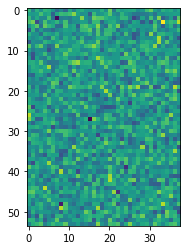

In [27]:
plt.imshow(x[1])

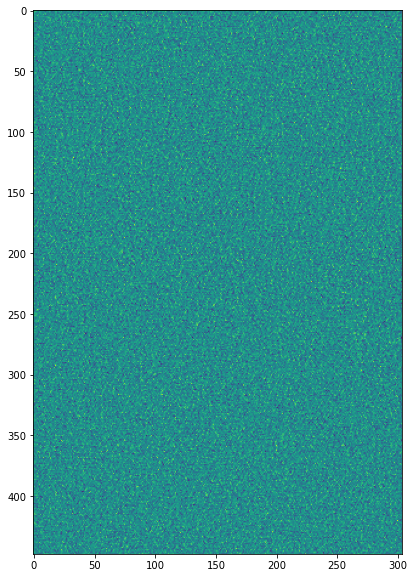

In [31]:
plt.figure(figsize = (15, 10))
plt.imshow(de_x[1][...,0])